MLP(
  (hidden_1): Linear(in_features=784, out_features=500)
  (hidden_2): Linear(in_features=500, out_features=250)
  (output): Linear(in_features=250, out_features=10)
)


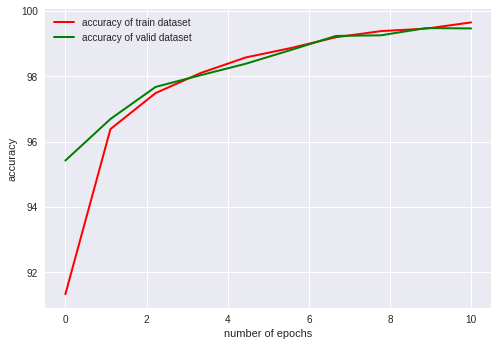

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plot
import numpy as np

# hyper parameters
train_num = 50000
valid_num = 10000
batch_size = 40
epochs = 10
learning_rate = 1e-2
momentum = 0.9
acc_train = Variable(torch.zeros(epochs, 1))
acc_valid = Variable(torch.zeros(epochs, 1))

# download mnist dataset
train_dataset = datasets.MNIST(root='./MNIST',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./MNIST',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# MLP network with two hidden layers
# input: features
# n_hidden_1: total number of first hidden layer units
# n_hidden_2: total number of second hidden layer units
# output: output
class MLP(nn.Module):
    def __init__(self, input, n_hidden_1, n_hidden_2, output):
        super(MLP, self).__init__()
        self.hidden_1 = nn.Linear(input, n_hidden_1)
        self.hidden_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.output = nn.Linear(n_hidden_2, output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        return F.log_softmax(self.output(x), dim=1)


# input dimensions
model = MLP(28 * 28, 500, 250, 10)
print(model)

# initialize bias
nn.init.constant(model.hidden_1.bias, 0)
nn.init.constant(model.hidden_2.bias, 0)
nn.init.constant(model.output.bias, 0)

# initialize weights
nn.init.xavier_uniform(model.hidden_1.weight, gain=1)
nn.init.xavier_uniform(model.hidden_2.weight, gain=1)
nn.init.xavier_uniform(model.output.weight, gain=1)

if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)

loss_function = nn.CrossEntropyLoss()

# iterations in epochs
for epoch in range(epochs):
    # print('epoch = %d' % epoch)
    loss = 0
    acc = 0

    for batch_index, (images, labels) in enumerate(train_loader):
        # set initial gradient to Zero firstly
        optimizer.zero_grad()

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        prediction = model(images)
        loss = loss_function(prediction, labels)

        acc = torch.max(prediction, 1)[1]

        # train dataset with 50000 training samples
        if (batch_index * batch_size) < train_num:

            acc_train[epoch,0]=acc_train[epoch,0]+acc.data.eq(labels.data).sum()

            loss.backward()
            optimizer.step()

        # vaild dataset with 10000 samples
        else:
            acc_valid[epoch,0]=acc_valid[epoch,0]+acc.data.eq(labels.data).sum()

    acc_train[epoch, 0] = (100 * acc_train[epoch, 0]) / train_num
    acc_valid[epoch, 0] = (100 * acc_valid[epoch, 0]) / valid_num
    #print(acc_train[epoch, 0])
    #print(acc_valid[epoch, 0])


x_axis = np.linspace(0, 10, 10)
plot.plot(x_axis, acc_train.data.numpy()[:,0],
          label = 'accuracy of train dataset', color ='r', lw=2)
plot.plot(x_axis, acc_valid.data.numpy()[:,0],
          label = 'accuracy of valid dataset', color = 'g', lw=2)
plot.xlabel("number of epochs")
plot.ylabel("accuracy")
plot.legend()
plot.show()
